In [15]:
# Part 5

import louvain
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cairo
import igraph as ig
import pandas as pd
pd.set_option('display.max_colwidth', -1)

dir = "part_5/"

# Load the nx graphs
PDC_closed = nx.read_weighted_edgelist("part_2/G_P_closed.nx",nodetype=int, create_using=nx.DiGraph())
PDC_open = nx.read_weighted_edgelist("part_2/G_P_open.nx",nodetype=int, create_using=nx.DiGraph())
DFT_closed = nx.read_weighted_edgelist("part_2/G_D_closed.nx",nodetype=int, create_using=nx.DiGraph())
DFT_open = nx.read_weighted_edgelist("part_2/G_D_open.nx",nodetype=int, create_using=nx.DiGraph())

# Set labels
df_f1 = pd.read_csv("part_2/" + "S040R01.csv")
nodes = np.arange(len(list(df_f1.columns)))
labels_number_to_channel = dict(zip(nodes, list(df_f1.columns)))
labels_channel_to_number = dict(zip(list(df_f1.columns), nodes))

# Rename the labels
#PDC_closed = nx.relabel_nodes(PDC_closed, labels)
#PDC_open = nx.relabel_nodes(PDC_open, labels)
#DFT_closed = nx.relabel_nodes(DFT_closed, labels)
#DFT_open = nx.relabel_nodes(DFT_open, labels)

# convert to igraph
def nx_to_ig(g):
    return ig.Graph.Adjacency((nx.to_numpy_matrix(g)).tolist())

# invert a dictionary
def invert(d):
    return dict( (v,k) for k in d for v in d[k] )

In [16]:
# Find clusters with louvain
def louvain_clusters(G,  map_names, name = "test"):
    '''
    Computes the clustering using Louvain with igraph for directed graphs
    :param G: networkx graph type
    :param name: text to the file exported
    :return: a dict with the clusters and nodes
    '''
    G = nx_to_ig(G)
    part = louvain.find_partition(G, louvain.ModularityVertexPartition)
    clusters = {}
    for i in range(len(part)):
        clusters[i] = part[i]
    print(clusters)
    clusters_for_df = {i: " ".join(map_names[e] for e in clusters[i]) for i in clusters}
    
    df = pd.DataFrame.from_dict(clusters_for_df, orient='index')
    df.columns = ["Channels"]
    df["Elements"] = [len(clusters[i]) for i in clusters]
    df["Community ID"] = df.index
    df = df[["Community ID", "Elements", "Channels"]]
    df.to_csv(dir + "table_51_" + name + ".csv", index=False)
    return clusters


#Things to plot colors on the plot
def plot_clusters(G, clusters, show_labels=False, name = "", title = ""):
    node_list = list(G.nodes())
    
    node_colors = []
    color_different = -1
    for i in node_list:
        inverted = invert(clusters)
        try:
            node_colors.append(inverted[i])
        except KeyError:
            node_colors.append(color_different)
            color_different = color_different - 1
    
    df = pd.read_csv("part_1/" + "channel_locations.txt", sep="\t")
    labels = df["label"].values
    labels = [label.replace(".", "") for label in labels]
    df.drop(["#", "label"], axis=1)
    df["label"] = labels
    
    number_to_coordinates = {labels_channel_to_number[df["label"].values[c]]: (df["x"].values[c], df["y"].values[c]) for c in range(len(df["label"].values))}
    fig = plt.figure(figsize=(10,8))
    d = nx.degree(G)
    node_size = [np.log10(np.power((v[1]),8))*150 for v in d]
    nx.draw(G, with_labels=show_labels, node_list=node_list, node_color=node_colors, pos=number_to_coordinates, node_size=node_size)
    plt.title(title)
    plt.savefig("part_5/topography_" + name + ".png")
    plt.show()
    return fig

{0: [1, 4, 5, 6, 7, 9, 10, 13, 14, 16, 20, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 59, 60, 61, 62, 63], 1: [0, 2, 3, 8, 15, 17, 18, 19, 21, 22, 27, 29, 47, 48, 49, 50, 51, 52, 53], 2: [23, 24, 25, 26, 28, 36, 38, 54, 56, 58], 3: [11, 12, 37, 44, 45, 46, 55, 57]}


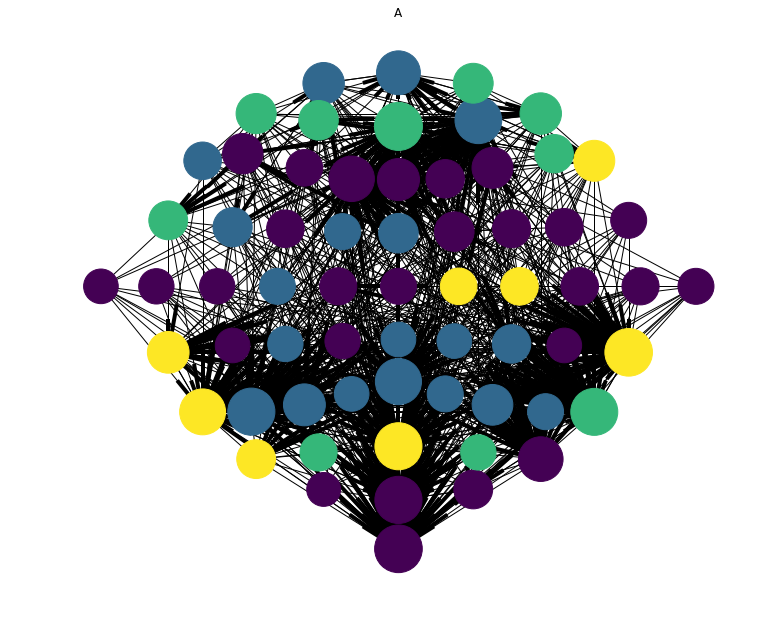

In [19]:
G = DFT_closed
name = "DFT_close"
clusters = louvain_clusters(G,labels_number_to_channel, name=name)
f1 = plot_clusters(G, clusters=clusters, name=name, title="A")

{0: [1, 4, 7, 8, 9, 12, 14, 15, 17, 19, 20, 26, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 57, 58, 59, 61], 1: [2, 5, 6, 10, 13, 24, 28, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 60], 2: [0, 3, 11, 18, 21, 30, 31, 32, 39, 48, 62], 3: [16, 22, 23, 25, 27, 29, 63]}


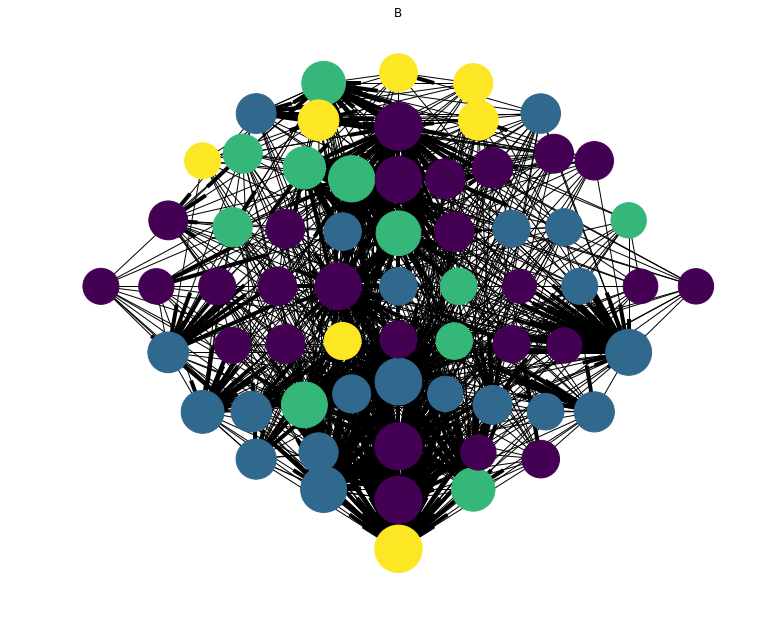

In [20]:
G = DFT_open
name = "DFT_open"
clusters = louvain_clusters(G,map_names=labels_number_to_channel, name=name)
f2 = plot_clusters(G, clusters=clusters, name=name, title="B")

{0: [2, 10, 14, 16, 19, 20, 26, 29, 30, 35, 37, 40, 42, 49, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], 1: [0, 3, 5, 7, 8, 11, 13, 18, 23, 24, 25, 27, 34, 44, 45, 46, 47, 48, 51, 52, 53], 2: [1, 4, 6, 9, 12, 15, 17, 21, 22, 28, 31, 32, 33, 36, 38, 39, 41, 43, 50]}


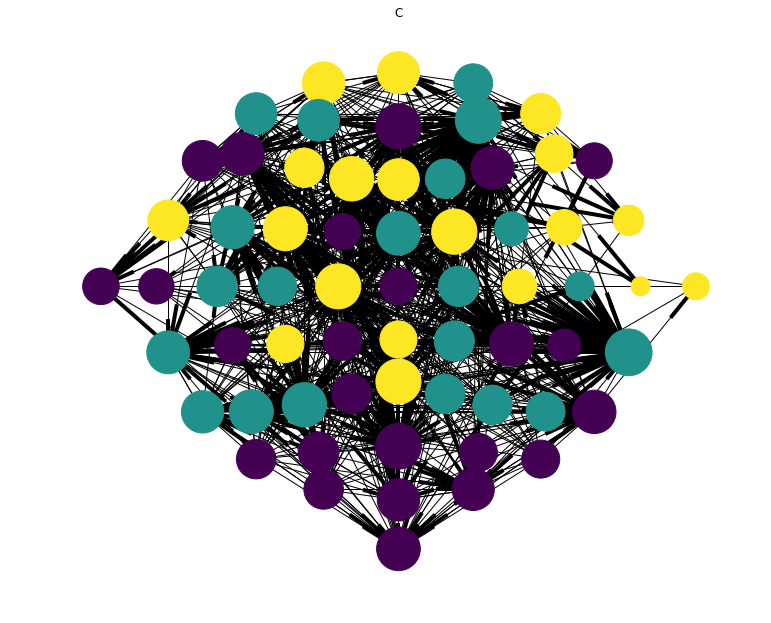

In [22]:
G = PDC_closed
name = "PDC_closed"
clusters = louvain_clusters(G,map_names=labels_number_to_channel, name=name)
f2 = plot_clusters(G, clusters=clusters, name=name, title="C")

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 19, 20, 21, 22, 24, 26, 27, 29, 30, 33, 34, 46], 1: [17, 31, 32, 42, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], 2: [12, 13, 18, 23, 25, 28, 35, 36, 37, 38, 39, 40, 41, 43, 44, 50]}


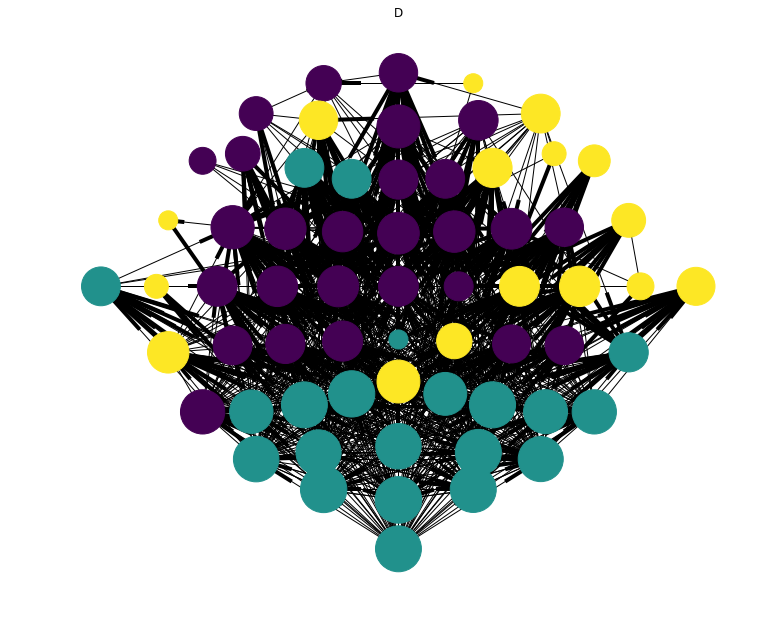

In [23]:
G = PDC_open
name = "PDC_open"
clusters = louvain_clusters(G,map_names=labels_number_to_channel, name=name)
f2 = plot_clusters(G, clusters=clusters, name=name, title="D")